<a href="https://colab.research.google.com/github/irfanizzath/Bioinformatics/blob/main/Microbe_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d mdwaquarazam/microorganism-image-classification

 80% 81.0M/101M [00:00<00:00, 113MB/s]
100% 101M/101M [00:00<00:00, 111MB/s] 


In [ ]:
!unzip /content/microorganism-image-classification.zip

Archive:  /content/microorganism-image-classification.zip
  inflating: Micro_Organism/Amoeba/Image_1.jpg  
  inflating: Micro_Organism/Amoeba/Image_10.jpg  
  inflating: Micro_Organism/Amoeba/Image_11.jpg  
  inflating: Micro_Organism/Amoeba/Image_14.jpg  
  inflating: Micro_Organism/Amoeba/Image_16.jpg  
  inflating: Micro_Organism/Amoeba/Image_17.jpg  
  inflating: Micro_Organism/Amoeba/Image_19.jpg  
  inflating: Micro_Organism/Amoeba/Image_2.jpg  
  inflating: Micro_Organism/Amoeba/Image_20.png  
  inflating: Micro_Organism/Amoeba/Image_21.jpg  
  inflating: Micro_Organism/Amoeba/Image_22.jpg  
  inflating: Micro_Organism/Amoeba/Image_23.jpg  
  inflating: Micro_Organism/Amoeba/Image_24.jpg  
  inflating: Micro_Organism/Amoeba/Image_25.jpg  
  inflating: Micro_Organism/Amoeba/Image_26.jpg  
  inflating: Micro_Organism/Amoeba/Image_27.jpg  
  inflating: Micro_Organism/Amoeba/Image_28.jpg  
  inflating: Micro_Organism/Amoeba/Image_30.jpg  
  inflating: Micro_Organism/Amoeba/Image_31.

In [ ]:
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import plotly.express as px
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout
from keras.callbacks import EarlyStopping as ES, ModelCheckpoint as MC
from tensorflow.keras.applications import ResNet50V2, ResNet50, InceptionV3, Xception

In [ ]:
gen = ImageDataGenerator(rescale=1./255, rotation_range=10, horizontal_flip=True, brightness_range=[0.3,0.8], validation_split=0.1)

In [ ]:
train_ds= gen.flow_from_directory(
    '/content/Micro_Organism/',
    batch_size=128,
    shuffle=True,
    class_mode='binary',
    target_size=(256,256),
    subset='training'
)
valid_ds= gen.flow_from_directory(
    '/content/Micro_Organism/',
    batch_size=64,
    shuffle=True,
    class_mode='binary',
    target_size=(256,256),
    subset='validation'
)


Found 714 images belonging to 8 classes.
Found 75 images belonging to 8 classes.


In [ ]:
class_names = sorted(os.listdir('/content/Micro_Organism/'))
n_classes = len(class_names)
print(class_names)
print(n_classes)

['Amoeba', 'Euglena', 'Hydra', 'Paramecium', 'Rod_bacteria', 'Spherical_bacteria', 'Spiral_bacteria', 'Yeast']
8


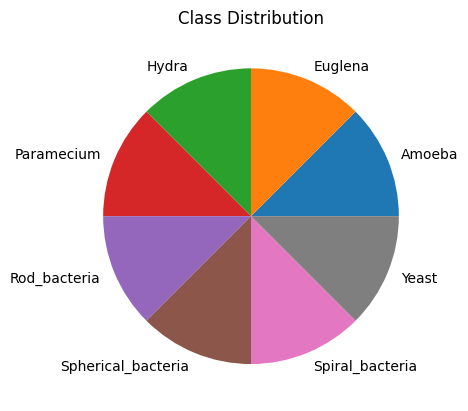

In [ ]:
# fig = px.pie(names=class_names, title="Class Distribution")
# fig.update_layout({'title':{'x':0.45}})
# fig.show()

# plt.pie(names=class_names, labels=class_names)
# plt.title("Class Distribution", loc="center", pad=20)
# plt.show()

plt.pie([1] * len(class_names), labels=class_names)
plt.title("Class Distribution", loc="center")
plt.show()

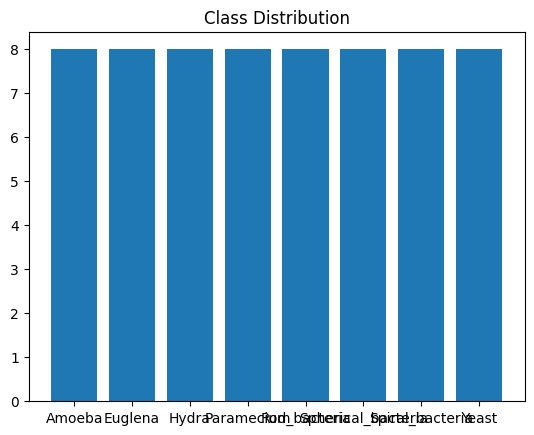

In [ ]:
plt.bar(class_names, n_classes)
plt.title("Class Distribution")

# Show the plot
plt.show()

In [ ]:
def show_images(data, GRID=[2,6], model=None, size=(25,10)):

    # The plotting configurations
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    plt.figure(figsize=size)

    # Data for visualization
    images, labels = next(iter(data)) # This process can take a little time because of the large batch size

    # Iterate through the subplots.
    for i in range(1, n_images+1):

        # Select a random data
        id = np.random.randint(len(images)) # This is a dynamic function because for validation data and training data, the length of total images is different.
        image, label = images[id], class_names[int(labels[id])]

        # Plot the sub plot
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        plt.axis('off')
        # If model is available make predictions.
        if model is not None:
            pred = class_names[np.argmax(model.predict(image[np.newaxis,...]))]
            title = f"Class : {label}\nPred : {pred}"
        else:
            title = f"Class : {label}"

        plt.title(title)
    plt.show()

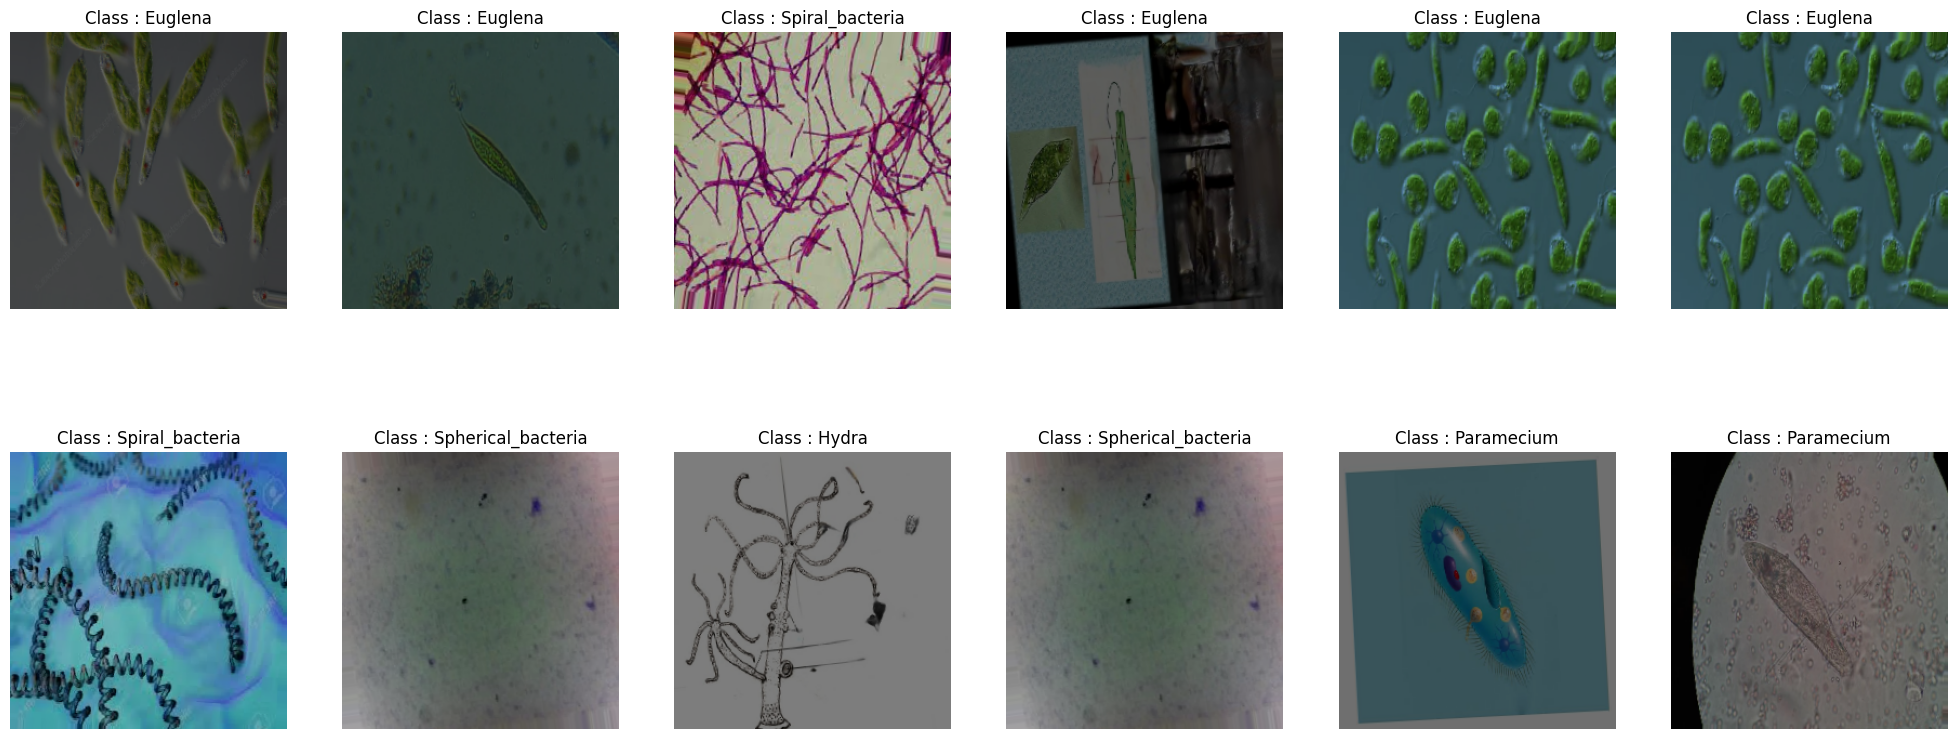

In [ ]:
show_images(data=train_ds)

In [ ]:
# Give you a model, a name
name = "inception-v3"

# Base model
base = InceptionV3(input_shape=(256,256,3), include_top=False)
base.trainable = False

# Model Architecture
model = Sequential([
    base, GAP(),
    Dense(256, kernel_initializer='he_normal', activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
])

# Callbacks
cbs = [ES(patience=3, restore_best_weights=True), MC(name + ".h5", save_best_only=True)]

# Compile Model
opt = tf.keras.optimizers.Adam(learning_rate=1e-3) # Higher than the default learning rate 1e-3
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Training
history = model.fit(train_ds, validation_data=valid_ds, epochs=50, callbacks=cbs)

Epoch 1/50
6/6 [==============================] - 163s 25s/step - loss: 2.4240 - accuracy: 0.1919 - val_loss: 1.7534 - val_accuracy: 0.3467
Epoch 2/50
6/6 [==============================] - 150s 24s/step - loss: 1.5989 - accuracy: 0.4300 - val_loss: 1.4484 - val_accuracy: 0.4933
Epoch 3/50
6/6 [==============================] - 150s 24s/step - loss: 1.2802 - accuracy: 0.5910 - val_loss: 1.1947 - val_accuracy: 0.6400
Epoch 4/50
6/6 [==============================] - 144s 23s/step - loss: 1.0861 - accuracy: 0.6275 - val_loss: 1.1117 - val_accuracy: 0.6267
Epoch 5/50
6/6 [==============================] - 150s 24s/step - loss: 0.9556 - accuracy: 0.6793 - val_loss: 1.0727 - val_accuracy: 0.6667
Epoch 6/50
6/6 [==============================] - 151s 26s/step - loss: 0.8529 - accuracy: 0.7353 - val_loss: 1.0097 - val_accuracy: 0.6800
Epoch 7/50
6/6 [==============================] - 144s 23s/step - loss: 0.7460 - accuracy: 0.7689 - val_loss: 0.9195 - val_accuracy: 0.7067
Epoch 8/50
6/6 [====

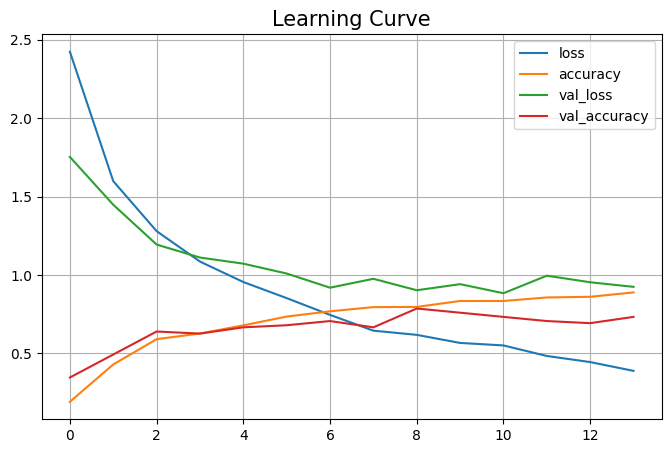

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title("Learning Curve", fontsize=15)
plt.grid()
plt.show()

1/1 [==============================] - 0s 182ms/step


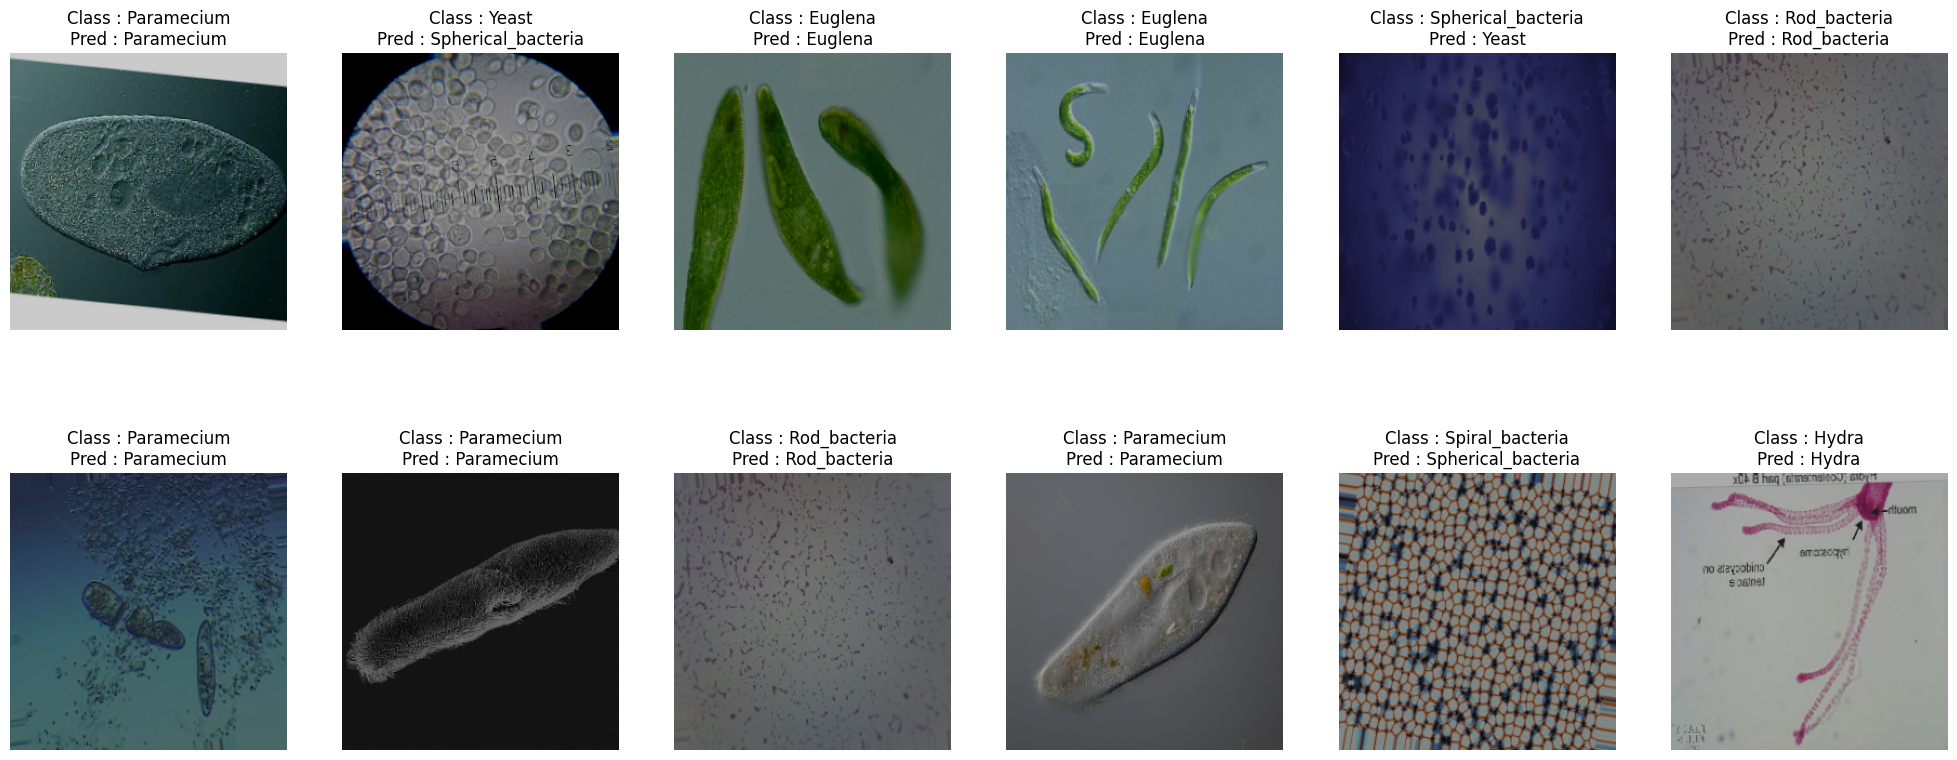

In [ ]:
show_images(data=valid_ds, model=model)

In [ ]:
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model
model = InceptionV3()

# Access the layers of the model
layers = model.layers

# Print the names of the layers
c=0
for layer in layers:
    print(layer.name)
    c+=1
print(c)

input_5
conv2d_376
batch_normalization_376
activation_376
conv2d_377
batch_normalization_377
activation_377
conv2d_378
batch_normalization_378
activation_378
max_pooling2d_16
conv2d_379
batch_normalization_379
activation_379
conv2d_380
batch_normalization_380
activation_380
max_pooling2d_17
conv2d_384
batch_normalization_384
activation_384
conv2d_382
conv2d_385
batch_normalization_382
batch_normalization_385
activation_382
activation_385
average_pooling2d_36
conv2d_381
conv2d_383
conv2d_386
conv2d_387
batch_normalization_381
batch_normalization_383
batch_normalization_386
batch_normalization_387
activation_381
activation_383
activation_386
activation_387
mixed0
conv2d_391
batch_normalization_391
activation_391
conv2d_389
conv2d_392
batch_normalization_389
batch_normalization_392
activation_389
activation_392
average_pooling2d_37
conv2d_388
conv2d_390
conv2d_393
conv2d_394
batch_normalization_388
batch_normalization_390
batch_normalization_393
batch_normalization_394
activation_388
acti

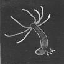

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

In [ ]:
img = image.load_img('amoeba.jpg',target_size=(192,192))
X=image.img_to_array(img)
X=np.expand_dims(X,axis=0)
pred=np.argmax(model.predict(X))
op=['Amoeba', 'Euglena', 'Hydra', 'Paramecium', 'Rod_bacteria', 'Spherical_bacteria', 'Spiral_bacteria', 'Yeast']
op[pred]

1/1 [==============================] - 0s 64ms/step


'Amoeba'

In [ ]:
model.save('microbeclassification.h5')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 22329384 (85.18 MB)
Trainable params: 526600 (2.01 MB)
Non-trainable params: 21802784 (83.17 MB)
_________